In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import AveragePooling2D,Dropout,Dense,Flatten,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet_v2 import preprocess_input

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [6]:
dataset=r'C:\Users\Ranjith ch\Mask detector\dataset'
image_path=list(paths.list_images(dataset))

In [7]:
data=[]
labels=[]

for i in image_path:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)

C:\Users\Ranjith ch\anaconda3\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [8]:
data=np.array(data,dtype='float32')
labels = np.array(labels)

In [9]:
data

array([[[[-0.94509804, -0.9764706 , -0.85882354],
         [-0.94509804, -0.9764706 , -0.85882354],
         [-0.94509804, -0.9764706 , -0.85882354],
         ...,
         [-0.8509804 , -0.90588236, -0.78039217],
         [-0.8509804 , -0.90588236, -0.78039217],
         [-0.84313726, -0.8980392 , -0.77254903]],

        [[-0.9137255 , -0.94509804, -0.827451  ],
         [-0.9137255 , -0.94509804, -0.827451  ],
         [-0.9137255 , -0.94509804, -0.827451  ],
         ...,
         [-0.7647059 , -0.79607844, -0.6784314 ],
         [-0.7647059 , -0.79607844, -0.6784314 ],
         [-0.75686276, -0.7882353 , -0.67058825]],

        [[-0.92156863, -0.9607843 , -0.8039216 ],
         [-0.92156863, -0.9607843 , -0.8039216 ],
         [-0.92156863, -0.9607843 , -0.8039216 ],
         ...,
         [-0.88235295, -0.8980392 , -0.7882353 ],
         [-0.8666667 , -0.88235295, -0.77254903],
         [-0.85882354, -0.8745098 , -0.7647059 ]],

        ...,

        [[ 0.3803922 , -0.9607843 , -0

In [10]:
labels

array(['without_mask', 'without_mask', 'without_mask', ..., 'with_mask',
       'with_mask', 'with_mask'], dtype='<U12')

In [11]:
data.shape

(3833, 224, 224, 3)

In [12]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [13]:
train_X,test_X,train_Y,test_Y=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [14]:
train_X.shape

(3066, 224, 224, 3)

In [15]:
train_Y.shape

(3066, 2)

In [16]:
aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [17]:
baseModel=ResNet152V2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

234553344/234545216 [==============================] - 22s 0us/step


In [18]:
baseModel.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [19]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)
model=Model(inputs=baseModel.input,outputs=headModel)

In [20]:
for layer in baseModel.layers:
    layer.trainable=False

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [22]:
learning_rate=0.001
Epochs=15
BS=32

In [23]:
opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
A=model.fit(
    aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(test_X,test_Y),
    validation_steps=len(test_X)//BS,
    epochs=Epochs
)





Epoch 1/15
95/95 [==============================] - 495s 5s/step - loss: 0.1433 - accuracy: 0.9489 - val_loss: 0.0287 - val_accuracy: 0.9909
Epoch 2/15
95/95 [==============================] - 1422s 15s/step - loss: 0.0703 - accuracy: 0.9726 - val_loss: 0.0229 - val_accuracy: 0.9922
Epoch 3/15
95/95 [==============================] - 902s 9s/step - loss: 0.0608 - accuracy: 0.9782 - val_loss: 0.0163 - val_accuracy: 0.9935
Epoch 4/15
95/95 [==============================] - 482s 5s/step - loss: 0.0439 - accuracy: 0.9848 - val_loss: 0.0149 - val_accuracy: 0.9948
Epoch 5/15
95/95 [==============================] - 3138s 33s/step - loss: 0.0453 - accuracy: 0.9845 - val_loss: 0.0105 - val_accuracy: 0.9974
Epoch 6/15
95/95 [==============================] - 371s 4s/step - loss: 0.0391 - accuracy: 0.9885 - val_loss: 0.0104 - val_accuracy: 0.9961
Epoch 7/15
95/95 [==============================] - 382s 4s/step - loss: 0.0440 - accuracy: 0.9852 - val_loss: 0.0134 - val_accuracy: 0.9935
Epoch 8/1

In [24]:
predict=model.predict(test_X,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_Y.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.99      0.99       383
without_mask       0.99      1.00      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(test_Y.argmax(axis=1),predict)

0.9947848761408083

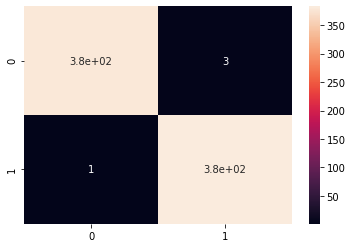

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_Y.argmax(axis=1), predict)
sns.heatmap(cm,annot=True)

In [28]:
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[380   3]
 [  1 383]]
acc: 0.9948
sensitivity: 0.9922
specificity: 0.9974


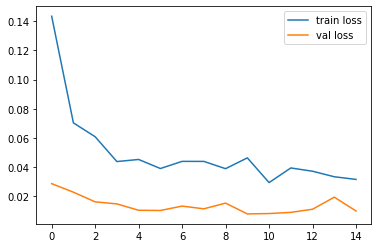

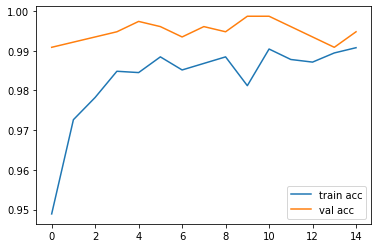

In [29]:
plt.plot(A.history['loss'], label='train loss')
plt.plot(A.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(A.history['accuracy'], label='train acc')
plt.plot(A.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

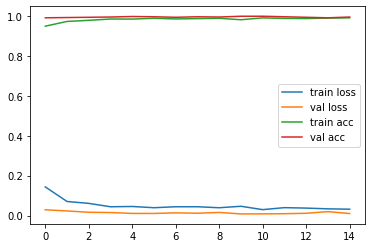

In [30]:
plt.plot(A.history['loss'], label='train loss')
plt.plot(A.history['val_loss'], label='val loss')
plt.plot(A.history['accuracy'], label='train acc')
plt.plot(A.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [31]:
model.save('ResNet15V2_model.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ResNet15V2_model.model\assets
